### Calculate observational biome means and uncertainty
#### mean: bootstrap one dataset per year, average over years, repeat 1000 times
#### stdev: back calculated such that +-3sd is range across datasets. 

In [1]:
import os
import xarray as xr
import pandas as pd
import dask
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
import functools
import glob
import scipy

In [2]:
import sys
sys.path.append('/glade/u/home/linnia/ctsm6_ppe/')
from utils.pyfunctions import *
utils_path = '/glade/u/home/linnia/ctsm6_ppe/utils/'

2025-07-17 18:27:33.846927: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 18:27:33.858533: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752798453.868862   46475 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752798453.873138   46475 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-17 18:27:33.888091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
def sudoku_biome_mean(ds):
    biome_masks=xr.open_dataset('~/ctsm6_ppe/biomes/sudoku_biomes_v3.nc')
    d='/glade/work/linnia/CLM6-PPE/BNF_v2.n01_ctsm5.3.012_transient_SP/run/'
    f=glob.glob(d+'*clm2.h0.*')[0]
    ds_sp=xr.open_dataset(f,decode_timedelta=False)
    
    biome_mean = ((ds_sp.area * ds_sp.landfrac * ds).groupby(biome_masks.sudoku_biomes).sum()
    / ((ds_sp.area * ds_sp.landfrac).groupby(biome_masks.sudoku_biomes).sum()))

    return biome_mean.compute()

In [4]:
def mc_mean(data, n_samples):
    # Extract the unique years from the data
    years = data["year"].values

    # Initialize a list to store the means for each Monte Carlo sample
    sample_means = []

    for _ in range(n_samples):
        sampled_values = []

        # For each year in the range, randomly select one dataset with a valid value
        for year in years:
            # Get the values for all datasets for the current year
            #values = data.sel(year=year).values
            values = data.sel(year=year).to_array().values

            # Identify datasets with non-NaN values
            valid_indices = np.where(~np.isnan(values))[0]

            if len(valid_indices) > 0:
                # Randomly select one of the valid datasets
                random_index = np.random.choice(valid_indices)
                sampled_value = values[random_index]
                sampled_values.append(sampled_value)
            else:
                raise ValueError(f"No valid datasets for year {year}")

        # Calculate the mean of the sampled values for this Monte Carlo iteration
        sample_means.append(np.mean(sampled_values))

    # Convert the sample means to a NumPy array
    sample_means = np.array(sample_means)

    # Compute the overall mean and standard deviation of the sample means
    mean_of_sample_means = np.mean(sample_means)
    std_of_sample_means = np.std(sample_means)

    return mean_of_sample_means, std_of_sample_means

In [5]:
def back_calc_stdev(data):
    
    data_arr = data.to_array()

    # Compute the range across data products
    vmin = data_arr.min(dim="variable")
    vmax = data_arr.max(dim="variable")
    vrange = vmax*1.1 - vmin*0.9

    # Assume range = 6σ (i.e., ±3σ covers the full expanded range)
    std_est = vrange / 6

    # Mean across time
    if 'year' in std_est.dims:
        std_est = std_est.mean(dim="year")

    return std_est


In [6]:
# create empty observational dataset
n_biomes=13
obs_biome = xr.Dataset({
        "LAI_mean": (("biome",), np.full(n_biomes, np.nan)),
        "LAI_stdev": (("biome",), np.full(n_biomes, np.nan)),
        "LAI_min": (("biome",), np.full(n_biomes,np.nan)),
        "LAI_max": (("biome",), np.full(n_biomes,np.nan)),
        "GPP_mean": (("biome",), np.full(n_biomes, np.nan)),
        "GPP_stdev": (("biome",), np.full(n_biomes, np.nan)),
        "GPP_min": (("biome",), np.full(n_biomes, np.nan)),
        "GPP_max": (("biome",), np.full(n_biomes, np.nan)),
        "LE_mean": (("biome",), np.full(n_biomes, np.nan)),
        "LE_stdev": (("biome",), np.full(n_biomes, np.nan)),
        "LE_min": (("biome",), np.full(n_biomes, np.nan)),
        "LE_max": (("biome",), np.full(n_biomes, np.nan)),
        "TVC_mean": (("biome",), np.full(n_biomes, np.nan)),
        "TVC_stdev": (("biome",), np.full(n_biomes, np.nan)),
        "TVC_min": (("biome",), np.full(n_biomes, np.nan)),
        "TVC_max": (("biome",), np.full(n_biomes, np.nan)),
        "SH_mean": (("biome",), np.full(n_biomes, np.nan)),
        "SH_stdev": (("biome",), np.full(n_biomes, np.nan)),
        "SH_min": (("biome",), np.full(n_biomes, np.nan)),
        "SH_max": (("biome",), np.full(n_biomes, np.nan))
    
    },coords={"biome": range(13)})


### Load PPE data

In [30]:
dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/'
ds = xr.open_dataset(dir+'ctsm6lhc_pxbmean_sudoku3_1985-2023.nc')
ds = ds.where(ds['crashed'] != 1, drop=True)

In [31]:
cf_gpp = 60*60*24 # gC/m2/day
cf_biomass = (1/1000) #gC/m2 to kgC/m2
gpp = cf_gpp*ds.GPP_biome_amean.sel(year=slice(2001,2015)).mean(dim='year').compute()
lai = ds.TLAI_biome_amax.sel(year=slice(2001,2020)).mean(dim='year').compute()
totvegc = cf_biomass*ds.TOTVEGC_biome_amean.sel(year=slice(2001,2019)).mean(dim='year').compute()

In [62]:
# load SH & ET
dir='/glade/work/linnia/CLM6-PPE/ctsm6_lhc/postp/'
ds = xr.open_dataset(dir+'ctsm6lhc_bmean_sudoku_1850-2023.nc')
ds = ds.where(ds['crashed'] != 1, drop=True)
et = ds.EFLX_LH_TOT_biome_amean.sel(year=slice(2000,2014)).mean(dim='year').compute()
sh = ds.FSH_biome_amean.sel(year=slice(2000,2014)).mean(dim='year').compute()

In [33]:
wfile='/glade/u/home/linnia/ctsm6_ppe/biomes/sudoku_biomes_v3.nc'
biome_masks=xr.open_dataset(wfile)
biome_names = biome_masks.biome_names

### Test

In [8]:
biome_masks=xr.open_dataset('~/ctsm6_ppe/biomes/sudoku_biomes_v3.nc')
d='/glade/work/linnia/CLM6-PPE/BNF_v2.n01_ctsm5.3.012_transient_SP/run/'
f=glob.glob(d+'*clm2.h0.*')[0]
ds_sp=xr.open_dataset(f,decode_timedelta=False)


In [20]:
da = (ds_sp.area * ds_sp.landfrac * lai_sp)

In [ ]:

biome_mean = ((ds_sp.area * ds_sp.landfrac * ds).groupby(biome_masks.sudoku_biomes).sum()
/ ((ds_sp.area * ds_sp.landfrac).groupby(biome_masks.sudoku_biomes).sum()))


### LAI 

In [7]:
#load the SP data
d='/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_SP_2/run/'
f=glob.glob(d+'*clm2.h0.*')[0]
ds_sp=fix_time(xr.open_dataset(f,decode_timedelta=False))
lai_sp = amax(ds_sp.TLAI).mean(dim='year')
lai_sp_bmean = sudoku_biome_mean(lai_sp)

In [8]:
# GIMMS LAI
ds = xr.open_dataset('/glade/work/linnia/datasets/GIMMS_LAI4g/GIMMS_LAI4g_V1.2_regridded/GIMMS_LAI4g_V1.2_2degConservative_noWeight_1982-2020_c071225.nc')
GIMMS = ds.sel(time=slice('2001','2020'))
lai_gimms = amax(GIMMS.LAI).compute()
lai_gimms_bmean = sudoku_biome_mean(lai_gimms)

In [9]:
ds = xr.open_dataset('/glade/work/linnia/datasets/GLASS/GLASS01J01.V60_2degConservative_noWeight_2001-2021_c071225.nc')
GLASS = ds.sel(time=slice('2001','2020')).rename({'latitude': 'lat', 'longitude': 'lon'})
lai_glass= amax(GLASS.LAI).compute()
lai_glass_bmean = sudoku_biome_mean(lai_glass)

In [10]:
ds = xr.open_dataset('/glade/work/linnia/datasets/GLOBMAP/GlobMapLAIV3_regridded/GlobMapLAIV3_2degConservative_noWeight_2000-2021_c071225.nc')
GLOBMAP = ds.sel(time=slice('2001','2020')).rename({'latitude': 'lat', 'longitude': 'lon'})
lai_globmap = amax(GLOBMAP.LAI).compute()
lai_globmap_bmean = sudoku_biome_mean(lai_globmap)

In [11]:
ds_lai_bmean = xr.Dataset({
    "GIMMS": lai_gimms_bmean,
    "GLASS": lai_glass_bmean,
    "GLOBMAP": lai_globmap_bmean,
})

In [12]:
### Calc mean and obs error
n_samples = 1000
p=0
for b in range(13):
    data = ds_lai_bmean.sel(sudoku_biomes=b)
    mn, se_mn = mc_mean(data, n_samples)
    product_std = back_calc_stdev(data)
    vmin = data.to_array().min(dim="variable").mean(dim='year')
    vmax = data.to_array().max(dim="variable").mean(dim='year')

    # append to ds:
    obs_biome["LAI_mean"].loc[{"biome": b}] = mn
    obs_biome["LAI_stdev"].loc[{"biome": b}] = product_std
    obs_biome["LAI_min"].loc[{"biome": b}] = vmin*0.9
    obs_biome["LAI_max"].loc[{"biome": b}] = vmax*1.1


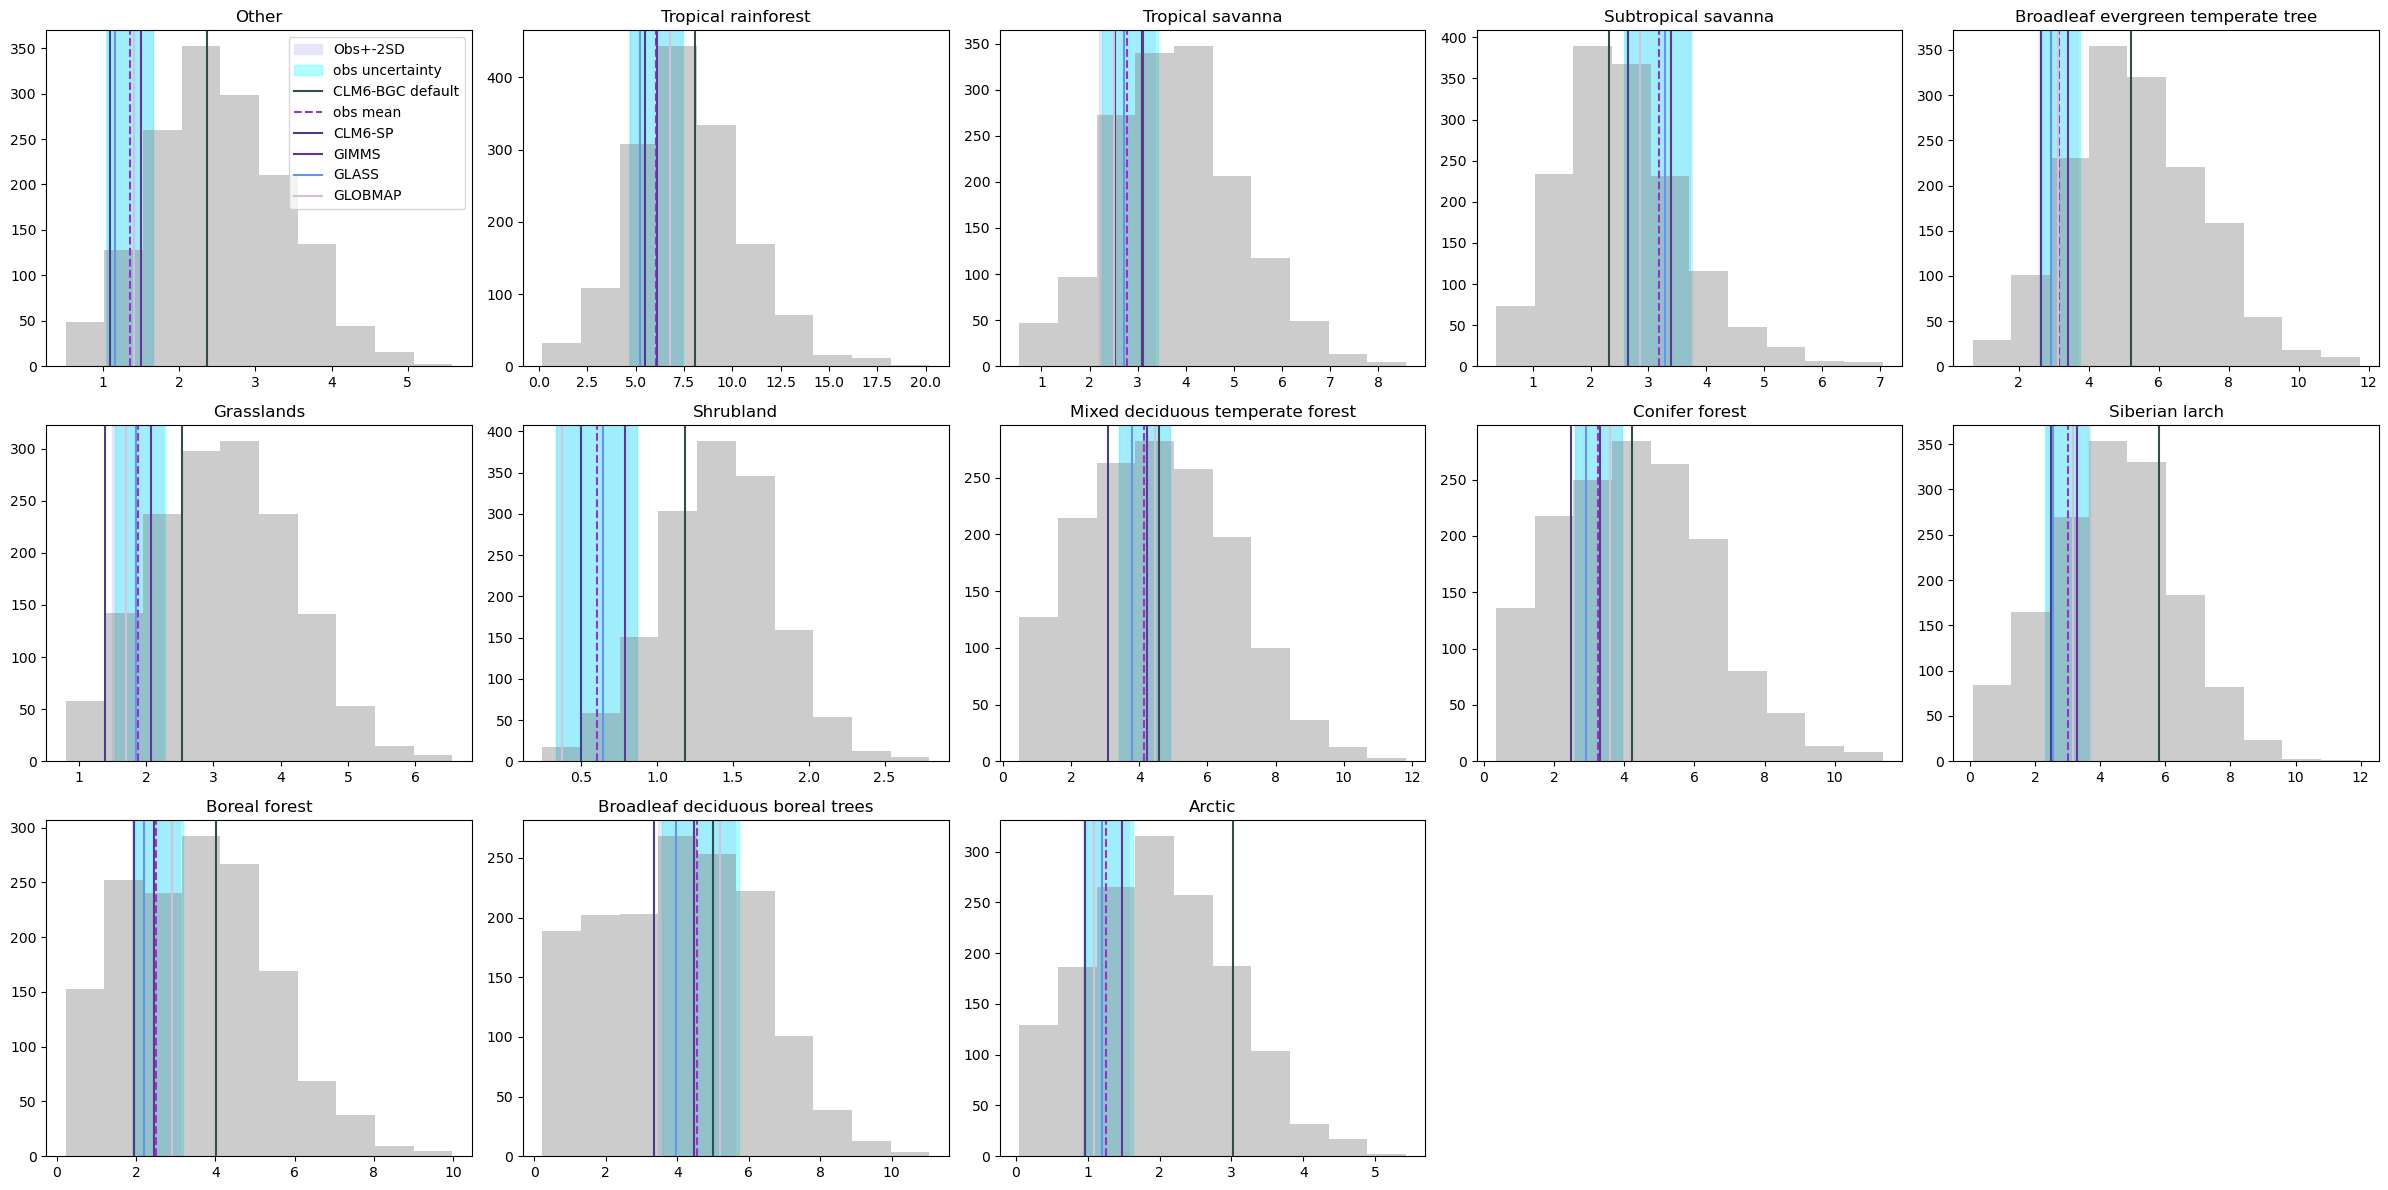

In [34]:
### plot
plt.figure(figsize=(24,12))
colors = ['rebeccapurple','cornflowerblue','thistle','plum','rebeccapurple','cornflowerblue','thistle','plum']

n_samples = 1000
p=0
for b in range(13):
    data = ds_lai_bmean.sel(sudoku_biomes=b)
    mn = obs_biome["LAI_mean"].loc[{"biome": b}]
    product_std = obs_biome["LAI_stdev"].loc[{"biome": b}]

    p=p+1
    plt.subplot(3,5,p)
    plt.axvspan(mn - 3*product_std, mn + 3*product_std, color='lavender', alpha=1, label="Obs+-2SD")
    plt.axvspan(obs_biome["LAI_min"].loc[{"biome":b}], obs_biome["LAI_max"].loc[{"biome":b}], color='aqua', alpha=0.3, label="obs uncertainty")
    plt.hist(lai.sel(biome=b),color='gray',alpha = 0.4)
    plt.axvline(lai.sel(biome=b,ens=0),c='darkslategrey',label='CLM6-BGC default')
    plt.axvline(mn,c='darkorchid',linestyle='--',label='obs mean')
    plt.axvline(lai_sp_bmean.sel(sudoku_biomes=b),color='darkslateblue',label='CLM6-SP')
    for d,dataset in enumerate(list(data.data_vars.keys())):
        plt.axvline(data[dataset].mean(dim='year'),c=colors[d],label=dataset)
    plt.title(biome_names[b].values)
    if b==0:
        plt.legend()
    
plt.tight_layout()
plt.savefig('./figs/biome_sudoku_obsvar_LAI_v3.png')

### GPP

In [14]:
# FLUXCOM-RS GPP # gC m-2 day-1
ds = xr.open_dataset('/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_regridded_2deg/FLUXCOM-RS_GPP_FR-ALL_MLM-ALL_2degConservative_noWeight_monthly_2001-2015_c071225.nc')
frs = ds.sel(time=slice('2001','2015'))
rs_gpp = amean(frs.GPP).compute() # gC m-2 day-1
gpp_rs_bmean = sudoku_biome_mean(rs_gpp)

In [15]:
# Add FLUXCOM-CRU
ds = xr.open_dataset('/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_METEO_regridded_2deg/FLUXCOM-RS_CRUJRA_v1_GPP_FR-ALL_MLM-ALL_2degConservative_noWeight_monthly_1950-2017_c071225.nc')
fcru = ds.sel(time=slice('2001','2015'))
cru_gpp = amean(fcru.GPP).compute()
gpp_cru_bmean = sudoku_biome_mean(cru_gpp)

In [16]:
# Add FLUXCOM-ERA
ds = xr.open_dataset('/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_METEO_regridded_2deg/FLUXCOM-RS_ERA5_GPP_FR-ALL_MLM-ALL_2degConservative_noWeight_monthly_1979-2018_c071225.nc')
fera = ds.sel(time=slice('2001','2015'))
era_gpp = amean(fera.GPP)
gpp_era_bmean = sudoku_biome_mean(era_gpp)

In [17]:
# Add FLUXCOM-GSWP3
ds = xr.open_dataset('/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_METEO_regridded_2deg/FLUXCOM-RS_GSWP3_GPP_FR-ALL_MLM-ALL_2degConservative_noWeight_monthly_1950-2010_c071225.nc')
gswp3 = ds.sel(time=slice('2001','2010'))
gswp3_gpp = amean(gswp3.GPP).compute()
gpp_gswp3_bmean = sudoku_biome_mean(gswp3_gpp)

In [18]:
# Add FLUXCOM-CERES-GPCP GPP # gC m-2 day-1
ds = xr.open_dataset('/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_METEO_regridded_2deg/FLUXCOM-RS_CERES_GPCP_GPP_FR-ALL_MLM-ALL_2degConservative_noWeight_monthly_2001-2014_c071225.nc')
gpcp = ds.sel(time=slice('2001','2010'))
gpcp_gpp = amean(gpcp.GPP).compute()
gpp_gpcp_bmean = sudoku_biome_mean(gpcp_gpp)

In [19]:
# FLUXCOM-WFDEI GPP # gC m-2 day-1
ds = xr.open_dataset('/glade/work/linnia/datasets/FLUXCOM/FLUXCOM-RS_METEO_regridded_2deg/FLUXCOM-RS_WFDEI_GPP_FR-ALL_MLM-ALL_2degConservative_noWeight_monthly_1979-2013_c071225.nc')
wrdei = ds.sel(time=slice('2001','2013'))
wrdei_gpp = amean(wrdei.GPP).compute()
gpp_wrdei_bmean = sudoku_biome_mean(wrdei_gpp)

In [20]:
# WECANN GPP # gC m-2 day-1
ds = xr.open_dataset('/glade/work/linnia/datasets/WECANN/WECANN_v1.0_2degConservative_noWeight_2007-2015_c071225.nc')
wecann = ds.sel(time=slice('2007','2015'))
wecann_gpp = amean(wecann.GPP).compute()
gpp_wecann_bmean = sudoku_biome_mean(wecann_gpp)

In [21]:
# GBAF GPP # gC m-2 day-1
ds = xr.open_dataset('/glade/work/linnia/datasets/GBAF/GBAF_2degConservative_noWeight_1982-2008_c071225.nc')
gbaf = ds.sel(time=slice('2001','2015'))
gbaf_gpp = amean(gbaf.GPP).compute() 
gpp_gbaf_bmean = sudoku_biome_mean(gbaf_gpp)

In [22]:
ds_gpp_biome = xr.Dataset({
    "FLUXCOM-RS": gpp_rs_bmean,
    "FLUXCOM-METEO-CRUJRA": gpp_cru_bmean,
    "FLUXCOM-METEO-ERA": gpp_era_bmean,
    "FLUXCOM-METEO-GSWP3": gpp_gswp3_bmean,
    "FLUXCOM-METEO-CERES": gpp_gpcp_bmean,
    "FLUXCOM-METEO-WRDEI": gpp_wrdei_bmean,
    "WECANN": gpp_wecann_bmean,
    "GBAF": gpp_gbaf_bmean
})

In [36]:
ds_gpp_biome.to_netcdf('../../data/sudoku_biomes/biome_gppmean_obs_gCm2day.nc')

In [23]:
### Calc mean and obs error
n_samples = 1000
for b in range(13):
    data = ds_gpp_biome.sel(sudoku_biomes=b)
    mn, se_mn = mc_mean(data, n_samples)
    #product_std = data.to_array().std(dim="variable").mean(dim='year')
    product_std = back_calc_stdev(data)
    vmin = data.to_array().min(dim="variable").mean(dim='year')
    vmax = data.to_array().max(dim="variable").mean(dim='year')

    # append to ds:
    obs_biome["GPP_mean"].loc[{"biome": b}] = mn
    obs_biome["GPP_min"].loc[{"biome": b}] = vmin*0.9
    obs_biome["GPP_max"].loc[{"biome": b}] = vmax*1.1
    obs_biome["GPP_stdev"].loc[{"biome": b}] = product_std


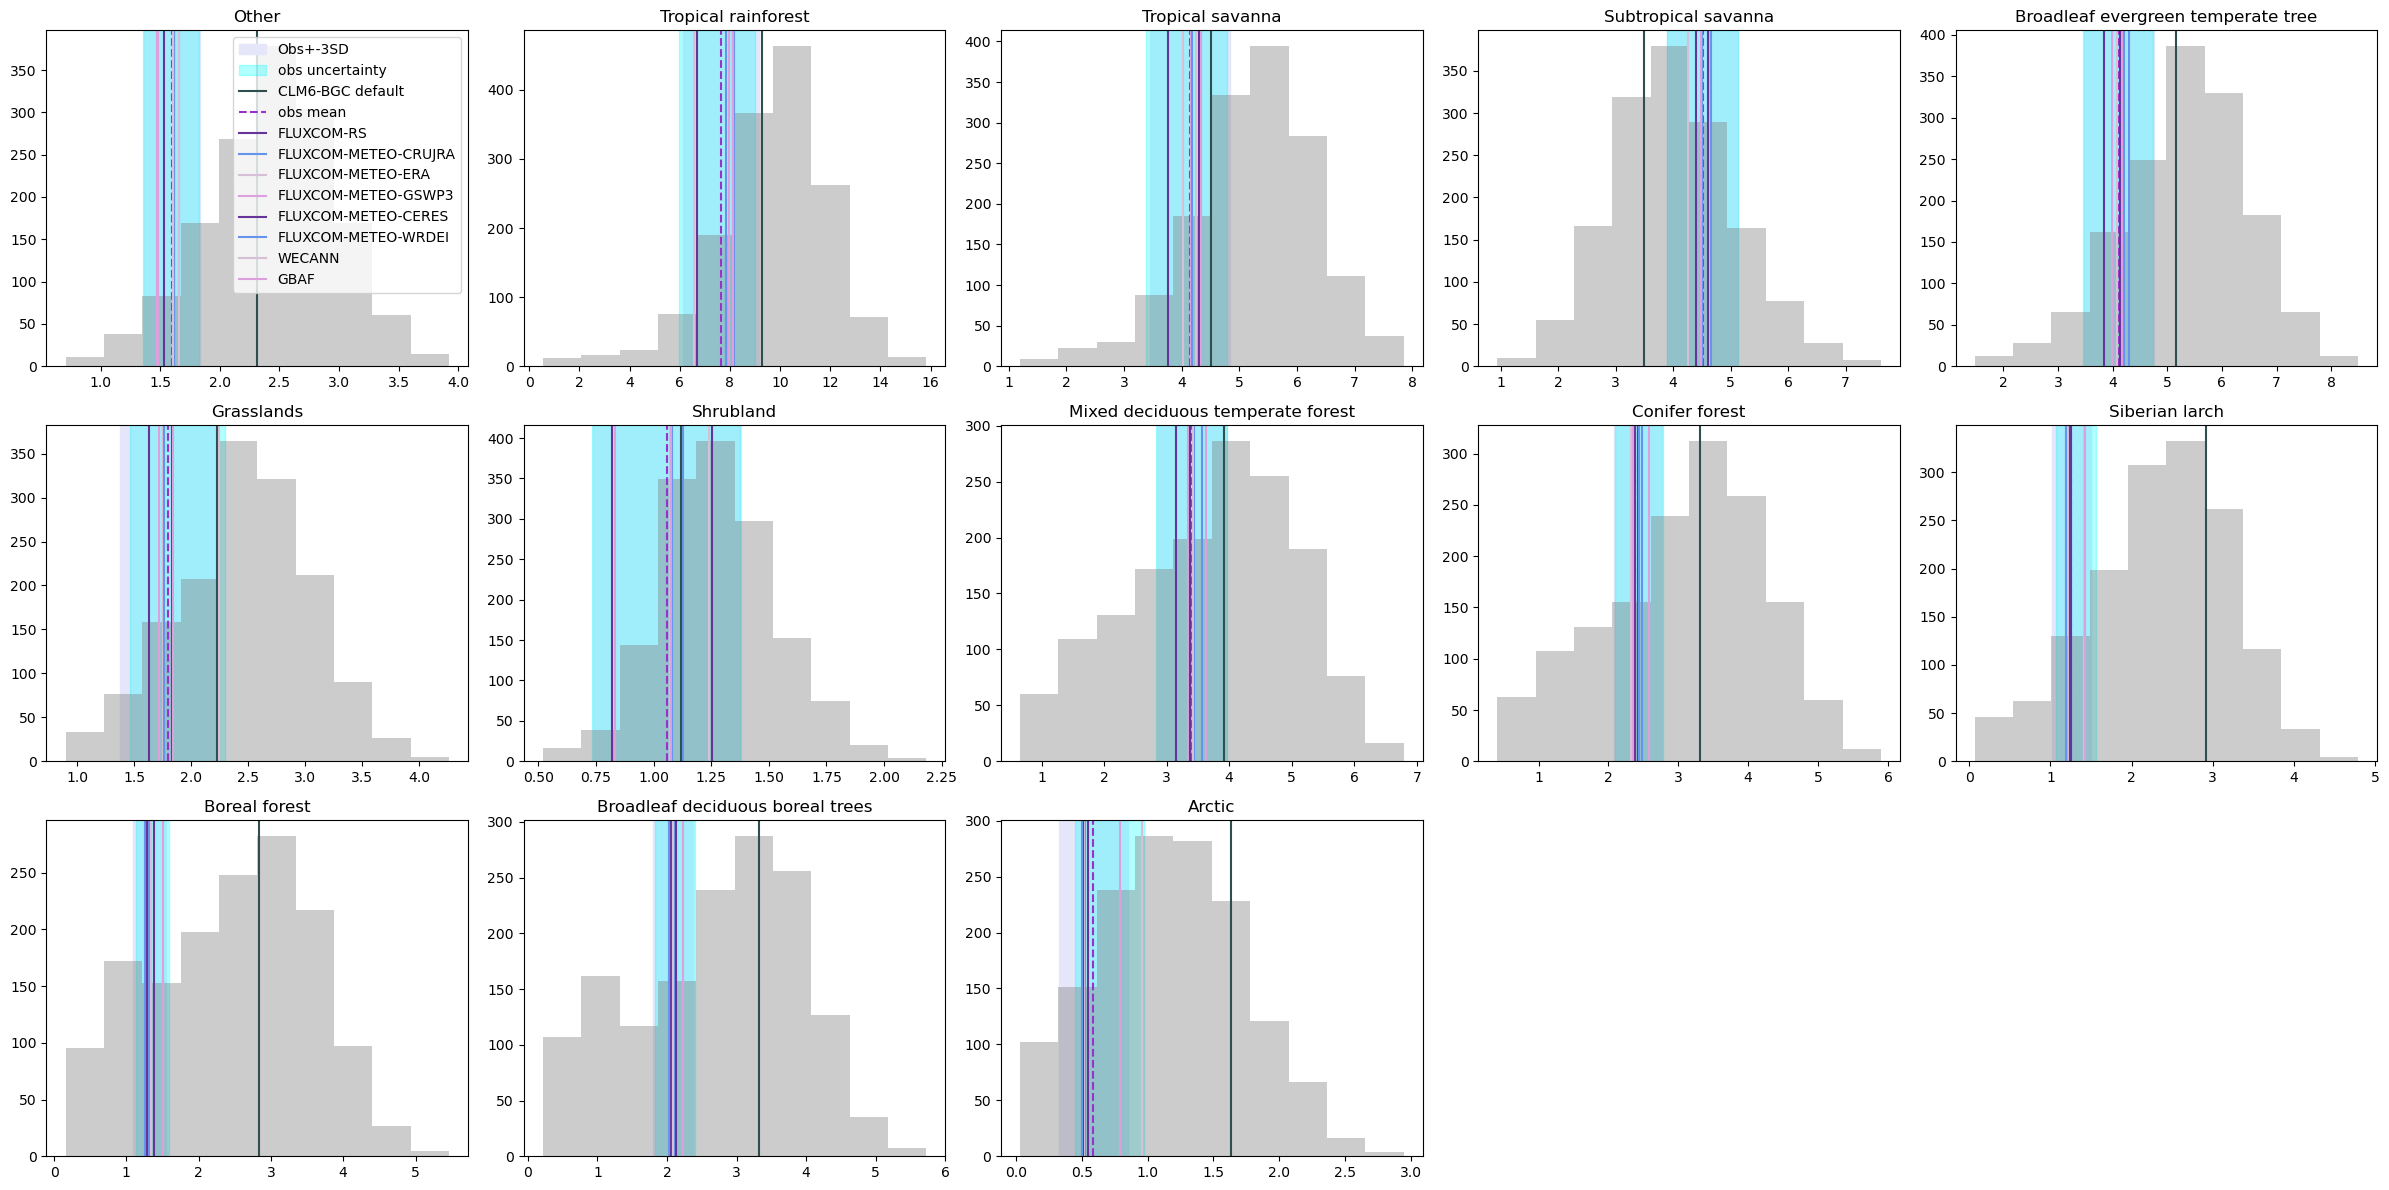

In [35]:

plt.figure(figsize=(24,12))
colors = ['rebeccapurple','cornflowerblue','thistle','plum','rebeccapurple','cornflowerblue','thistle','plum']

p=0
for b in range(13):
    data = ds_gpp_biome.sel(sudoku_biomes=b)
    mn = obs_biome["GPP_mean"].loc[{"biome": b}]
    product_std = obs_biome["GPP_stdev"].loc[{"biome": b}]

    p=p+1
    plt.subplot(3,5,p)
    plt.axvspan(mn - 3*product_std, mn + 3*product_std, color='lavender', alpha=1, label="Obs+-3SD")
    plt.axvspan(obs_biome["GPP_min"].loc[{"biome":b}],obs_biome["GPP_max"].loc[{"biome":b}],color='aqua',alpha=0.3,label='obs uncertainty')
    plt.hist(gpp.sel(biome=b),color='gray',alpha = 0.4)
    plt.axvline(gpp.sel(biome=b,ens=0),c='darkslategrey',label='CLM6-BGC default')
    plt.axvline(mn,c='darkorchid',linestyle='--',label='obs mean')
    for d,dataset in enumerate(list(data.data_vars.keys())):
        plt.axvline(data[dataset].mean(dim='year'),c=colors[d],label=dataset)
    plt.title(biome_names[b].values)
    if b==0:
        plt.legend()
    
plt.tight_layout()
plt.savefig('./figs/biome_sudoku_obsvar_GPP_v3.png')

### Biomass

In [24]:
# Xu Saatchi
cf = 0.1 # convert MgC/ha to kgC/m2
ds = xr.open_dataset('/glade/work/linnia/datasets/biomass/XuSaatchi2021_biomass_2degConservative_noWeight_2000-2019_c071225.nc')
xu = cf*ds.sel(time=slice('2000','2019'))
biomass_xu_bmean = sudoku_biome_mean(xu.totwoodC)
biomass_xu_bmean = biomass_xu_bmean.mean(dim='time')

In [25]:
# ESACCI
cf = 0.1*0.5*(1/0.7) # convert MgC/ha to kgC/m2 and AGB to TOTVEGC
ds = xr.open_dataset('/glade/work/linnia/datasets/biomass/ESACCI_biomass_2degConservative_noWeight_2010_c071225.nc')
esacci_biomass = cf*ds.agb.mean(dim='time').compute()
biomass_esacci_bmean = sudoku_biome_mean(esacci_biomass)

In [26]:
# GEOCARBON
cf = 0.1*0.5*(1/0.7) # convert MgC/ha to kgC/m2 and AGB to TOTVEGC
ds = xr.open_dataset('/glade/work/linnia/datasets/biomass/GEOCARBON_biomass_2degConservative_noWeight_2010_c071225.nc')
geocarbon_biomass = (cf*ds.agb).mean(dim='time').compute()
biomass_geo_bmean = sudoku_biome_mean(geocarbon_biomass)

In [27]:
ds_biomass_biome = xr.Dataset({
    "XuSaatchi": biomass_xu_bmean,
    "ESACCI": biomass_esacci_bmean,
    "GEOCARBON": biomass_geo_bmean,
})

In [28]:
### Calc mean and obs error
for b in range(13):
    data = ds_biomass_biome.sel(sudoku_biomes=b)
    mn = ds_biomass_biome.sel(sudoku_biomes=b).to_array().mean(dim="variable")
    #product_std = data.to_array().std(dim="variable")
    product_std = back_calc_stdev(data)
    vmin = data.to_array().min(dim="variable")
    vmax = data.to_array().max(dim="variable")

    # append to ds:
    obs_biome["TVC_mean"].loc[{"biome": b}] = mn
    obs_biome["TVC_min"].loc[{"biome": b}] = max(0,vmin*0.9)
    obs_biome["TVC_max"].loc[{"biome": b}] = vmax*1.1
    obs_biome["TVC_stdev"].loc[{"biome": b}] = product_std


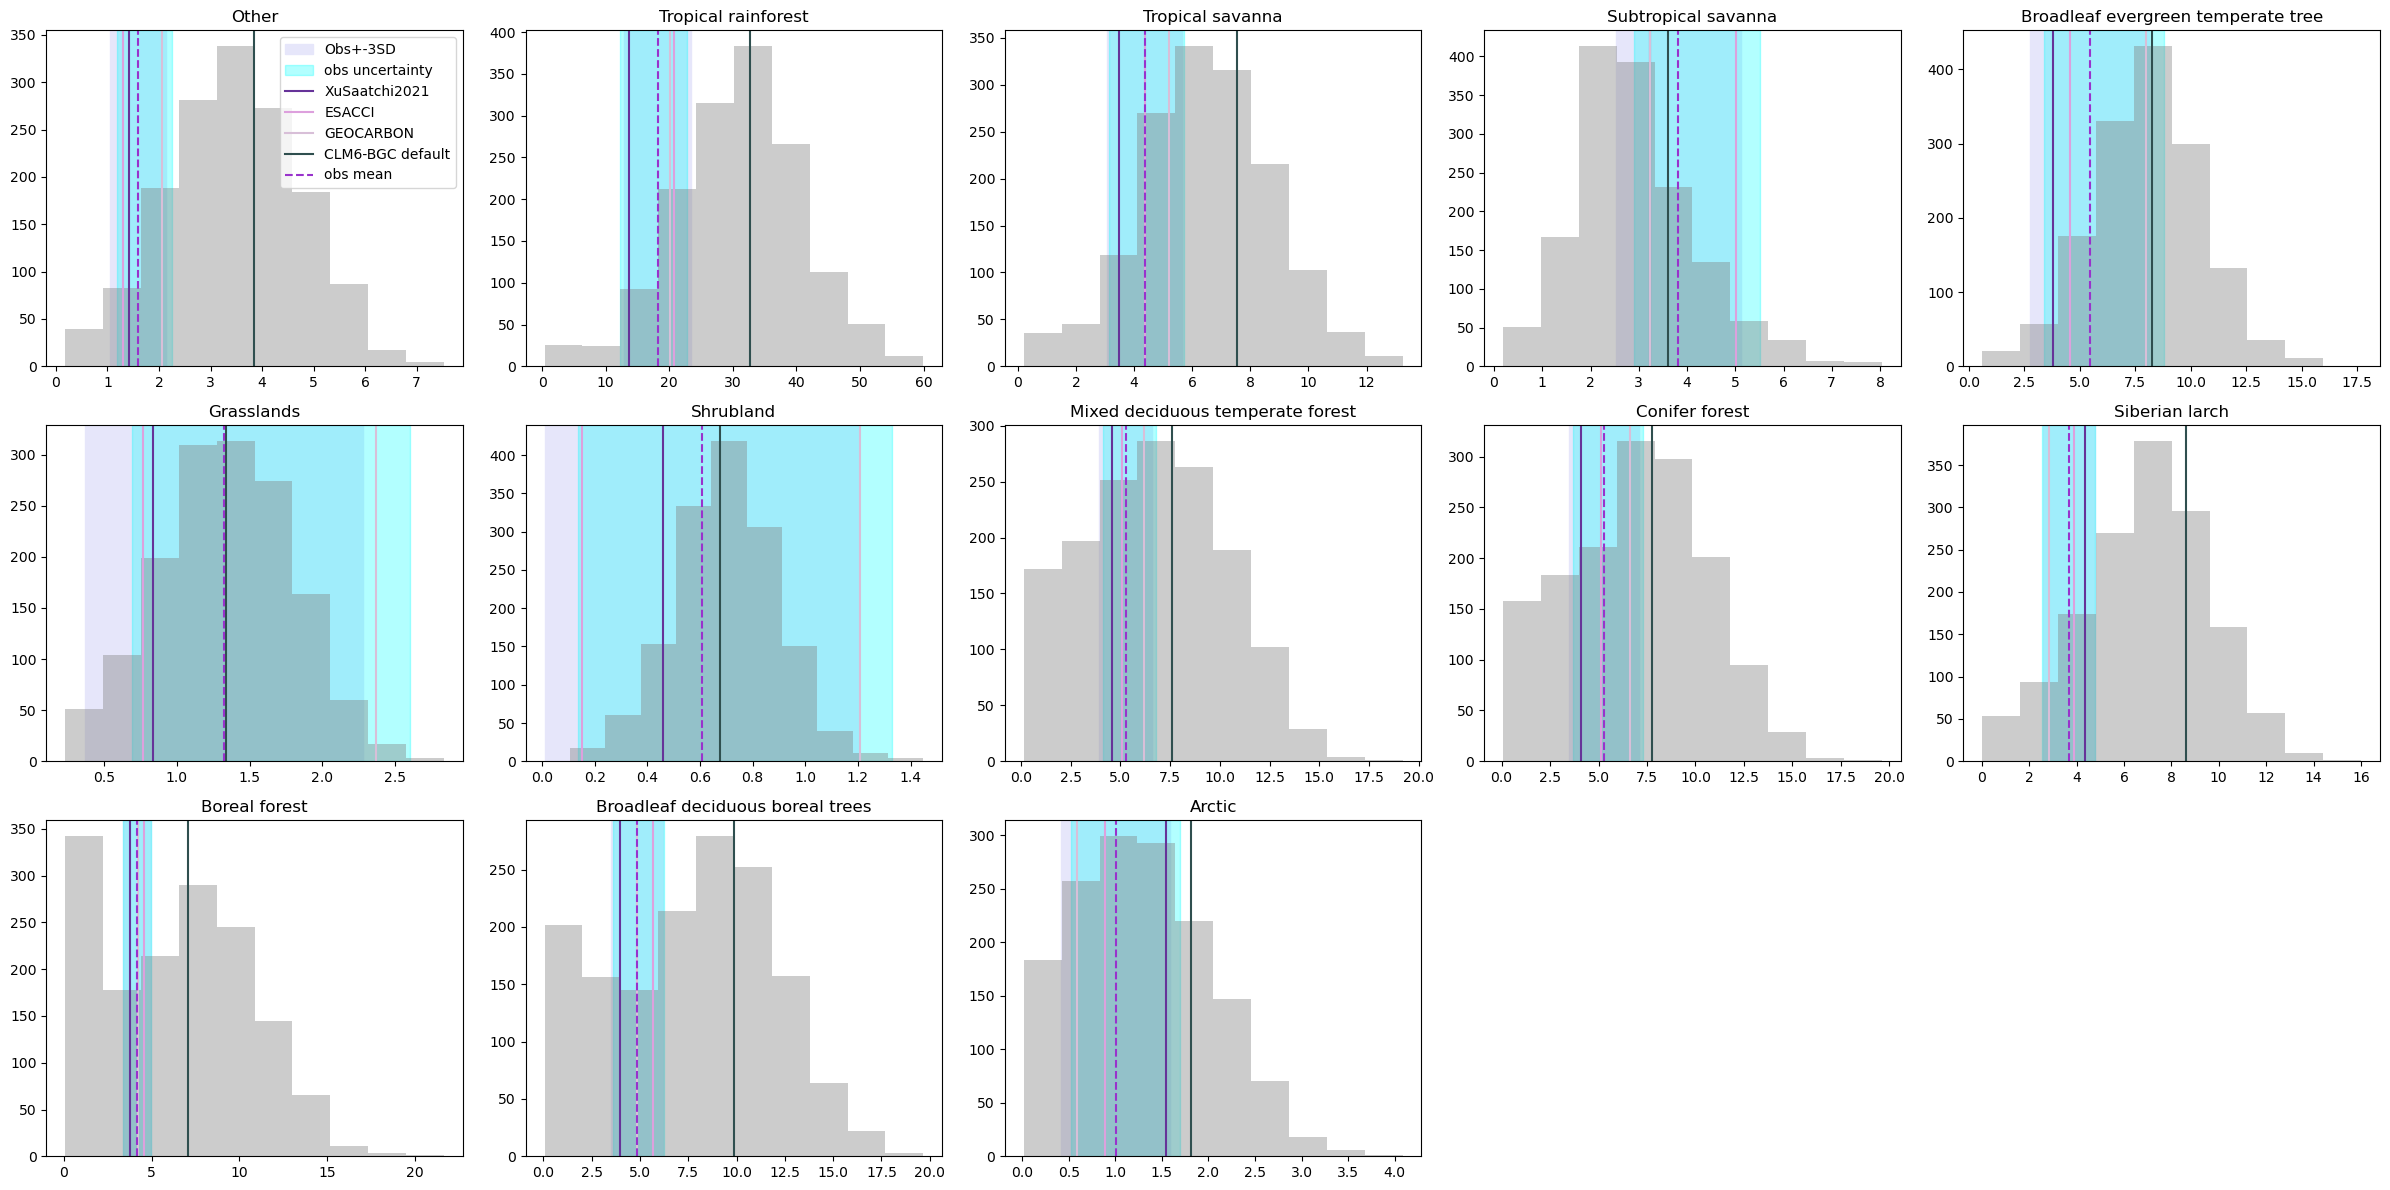

In [36]:
### plot
plt.figure(figsize=(24,12))
colors = ['rebeccapurple','cornflowerblue','thistle','plum','rebeccapurple','cornflowerblue','thistle','plum']

p=0
for b in range(13):
    data = ds_biomass_biome.sel(sudoku_biomes=b)
    mn = obs_biome["TVC_mean"].loc[{"biome": b}]
    product_std = obs_biome["TVC_stdev"].loc[{"biome": b}]

    p=p+1
    plt.subplot(3,5,p)
    plt.axvspan(mn - 3*product_std, mn + 3*product_std, color='lavender', alpha=1, label="Obs+-3SD")
    plt.axvspan(obs_biome["TVC_min"].loc[{"biome":b}],obs_biome["TVC_max"].loc[{"biome":b}],color='aqua',alpha=0.3,label='obs uncertainty')
    plt.hist(totvegc.sel(biome=b),color='gray',alpha = 0.4)

    plt.axvline(biomass_xu_bmean.sel(sudoku_biomes=b),c=colors[0],label='XuSaatchi2021')
    plt.axvline(biomass_esacci_bmean.sel(sudoku_biomes=b),c=colors[3],label='ESACCI')
    plt.axvline(biomass_geo_bmean.sel(sudoku_biomes=b),c=colors[6],label='GEOCARBON')
    
    plt.axvline(totvegc.sel(biome=b,ens=0),c='darkslategrey',label='CLM6-BGC default')
    plt.axvline(mn,c='darkorchid',linestyle='--',label='obs mean')
    plt.title(biome_names[b].values)
    if b==0:
        plt.legend()
    
plt.tight_layout()
plt.savefig('./figs/biome_sudoku_obsvar_biomass_v3.png')

### Evapotranspiration

In [37]:
# CLASS ET W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/CLASS_LE.nc')
da = ds.le
et_class_bmean = sudoku_biome_mean(da).sel(year=slice('2000','2014'))

In [38]:
# DOLCE ET W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/DOLCE_LE.nc')
et_dolce_bmean = sudoku_biome_mean(ds.le).sel(year=slice('2000','2014'))

In [39]:
# GBAF ET W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/GBAF_LE.nc')
et_gbaf_bmean = sudoku_biome_mean(ds.le).sel(year=slice('2000','2014'))

In [40]:
# FLUXCOM ET W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/FLUXCOM_LE.nc')
et_fluxcom_bmean = sudoku_biome_mean(ds.le).sel(year=slice('2000','2014'))

In [41]:
# WECANN ET W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/WECANN_LE.nc')
et_wecann_bmean = sudoku_biome_mean(ds.le).sel(year=slice('2000','2014'))

In [42]:
ds_et_biome = xr.Dataset({
    "CLASS": et_class_bmean,
    "DOLCE": et_dolce_bmean,
    "FLUXCOM": et_fluxcom_bmean,
    "GBAF": et_gbaf_bmean,
    "WECANN": et_wecann_bmean
})

In [43]:
### Calc mean and obs error
n_samples = 1000
for b in range(14):
    data = ds_et_biome.sel(sudoku_biomes=b)
    mn, se_mn = mc_mean(data, n_samples)
    #product_std = data.to_array().std(dim="variable").mean(dim='year')
    product_std = back_calc_stdev(data)
    vmin = data.to_array().min(dim="variable").mean(dim='year')
    vmax = data.to_array().max(dim="variable").mean(dim='year')
    
    # append to ds:
    obs_biome["LE_mean"].loc[{"biome": b}] = mn
    obs_biome["LE_min"].loc[{"biome": b}] = vmin*0.9
    obs_biome["LE_max"].loc[{"biome": b}] = vmax*1.1
    obs_biome["LE_stdev"].loc[{"biome": b}] = product_std


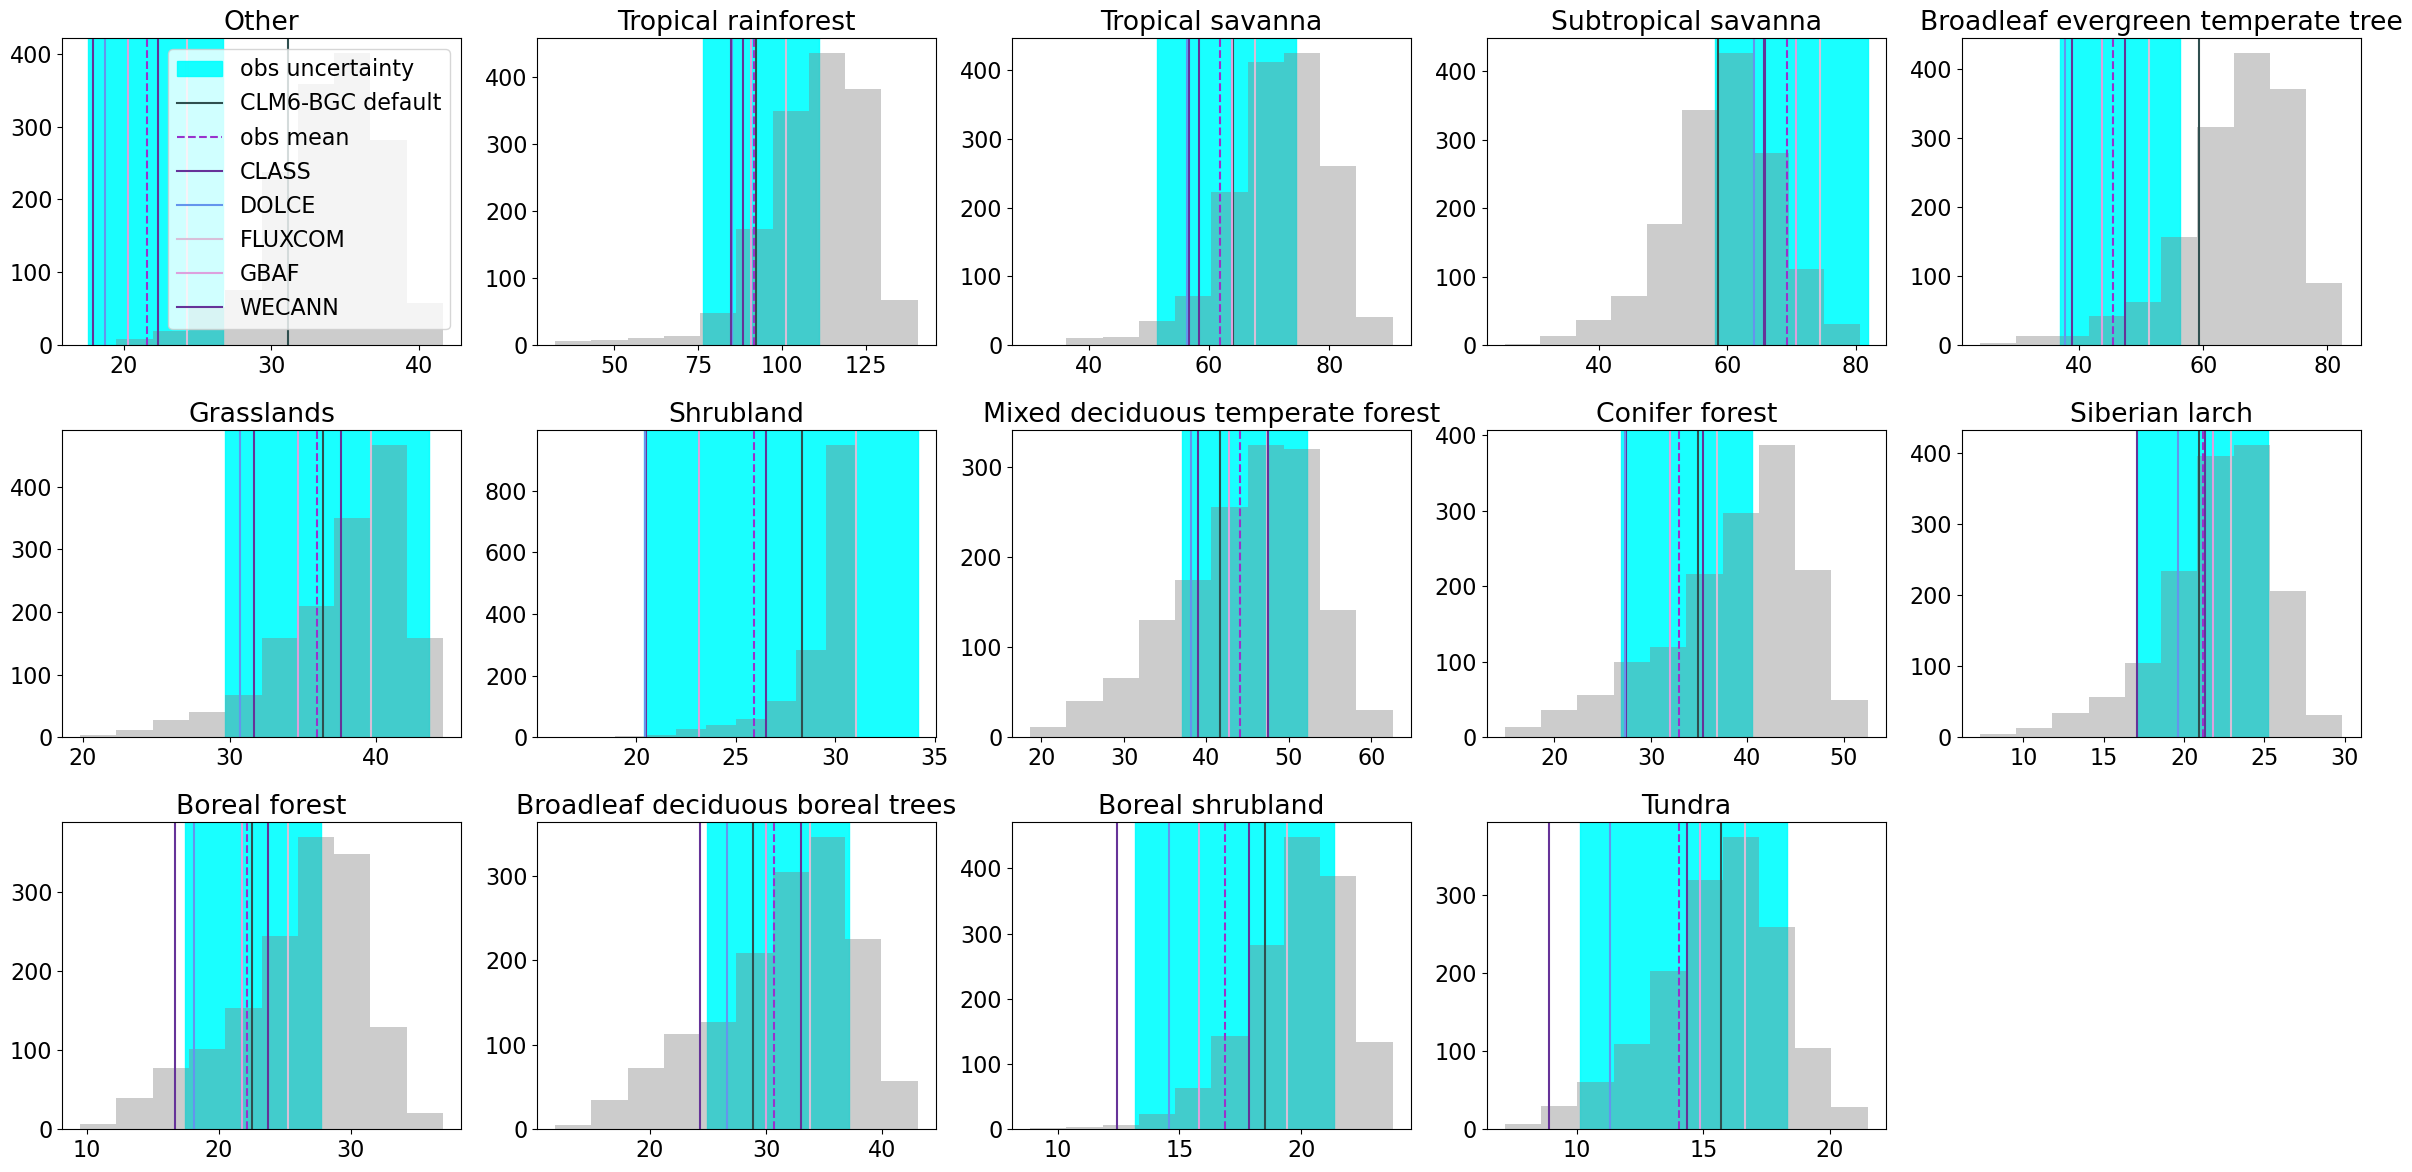

In [44]:
### Calc mean and obs error
plt.figure(figsize=(24,12))
plt.rcParams.update({'font.size': 16})
colors = ['rebeccapurple','cornflowerblue','thistle','plum','rebeccapurple','cornflowerblue','thistle','plum']

n_samples = 1000
p=0
for b in range(14):
    data = ds_et_biome.sel(sudoku_biomes=b)
    mn = obs_biome["LE_mean"].loc[{"biome": b}]
    product_std = obs_biome["LE_stdev"].loc[{"biome": b}]

    p=p+1
    plt.subplot(3,5,p)
    #plt.axvspan(mn - 3*product_std, mn + 3*product_std, color='lavender', alpha=0.9, label="Obs+-3SD")
    plt.axvspan(obs_biome["LE_min"].loc[{"biome": b}],obs_biome["LE_max"].loc[{"biome": b}],color='aqua',alpha=0.9,label='obs uncertainty')
    plt.hist(et.sel(biome=b),color='gray',alpha = 0.4)
    plt.axvline(et.sel(biome=b,ens=0),c='darkslategrey',label='CLM6-BGC default')
    plt.axvline(mn,c='darkorchid',linestyle='--',label='obs mean')
    for d,dataset in enumerate(list(data.data_vars.keys())):
        plt.axvline(data[dataset].mean(dim='year'),c=colors[d],label=dataset)
    plt.title(biome_names[b].values)
    if b==0:
        plt.legend()
    
plt.tight_layout()
plt.savefig('./figs/biome_sudoku_obsvar_LE.png')

### SH

In [109]:
# CLASS SH W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/CLASS_SH.nc')
sh_class_bmean = sudoku_biome_mean(ds.sh).sel(year=slice('2000','2014'))

In [110]:
# GBAF SH W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/GBAF_SH.nc')
sh_gbaf_bmean = sudoku_biome_mean(ds.sh).sel(year=slice('2000','2014'))

In [111]:
# FLUXCOM SH W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/FLUXCOM_SH.nc')
sh_fluxcom_bmean = sudoku_biome_mean(ds.sh).sel(year=slice('2000','2014'))

In [112]:
# WECANN SH W/m2
ds = xr.open_dataset('/glade/work/afoster/FATES_calibration/observations/ILAMB_obs/WECANN_SH.nc')
sh_wecann_bmean = sudoku_biome_mean(ds.sh).sel(year=slice('2000','2014'))

In [113]:
ds_sh_biome = xr.Dataset({
    "CLASS": sh_class_bmean,
    "FLUXCOM": sh_fluxcom_bmean,
    "GBAF": sh_gbaf_bmean,
    "WECANN": sh_wecann_bmean
})

In [125]:
### Calc mean and obs error
n_samples = 1000
for b in range(14):
    data = ds_sh_biome.sel(sudoku_biomes=b)
    mn, se_mn = mc_mean(data, n_samples)
    #product_std = data.to_array().std(dim="variable").mean(dim='year')
    product_std = back_calc_stdev(data)
    vmin = data.to_array().min(dim="variable").mean(dim='year')
    vmax = data.to_array().max(dim="variable").mean(dim='year')
    
    # append to ds:
    obs_biome["SH_mean"].loc[{"biome": b}] = mn
    obs_biome["SH_min"].loc[{"biome": b}] = vmin*0.9
    obs_biome["SH_max"].loc[{"biome": b}] = vmax*1.1
    obs_biome["SH_stdev"].loc[{"biome": b}] = product_std


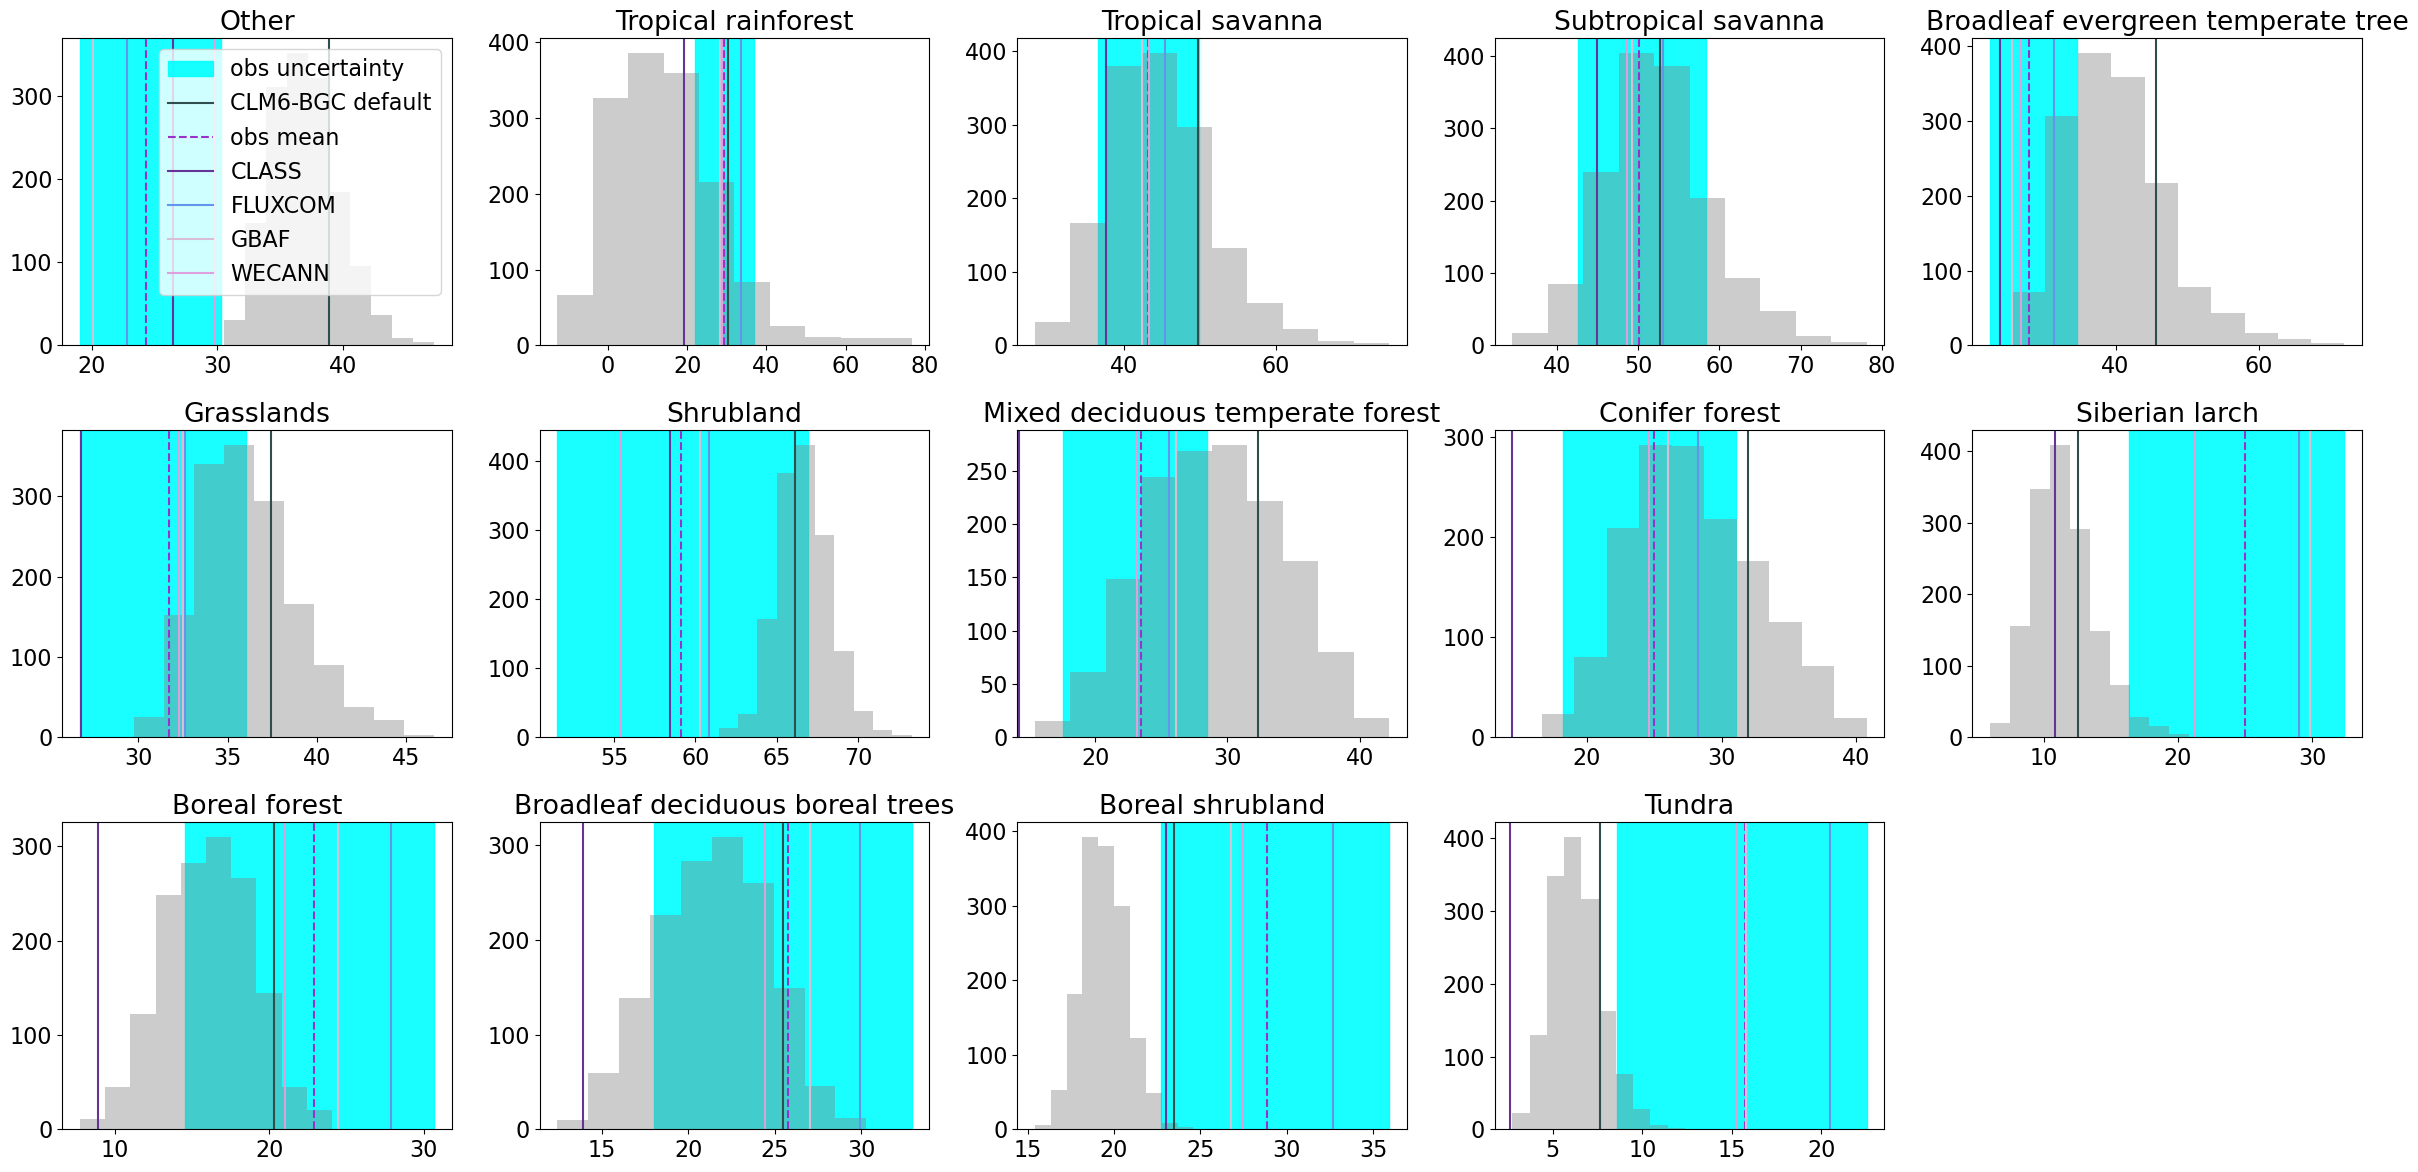

In [126]:
### Calc mean and obs error
plt.figure(figsize=(24,12))
plt.rcParams.update({'font.size': 16})
colors = ['rebeccapurple','cornflowerblue','thistle','plum','rebeccapurple','cornflowerblue','thistle','plum']

n_samples = 1000
p=0
for b in range(14):
    data = ds_sh_biome.sel(sudoku_biomes=b)
    mn = obs_biome["SH_mean"].loc[{"biome": b}]
    product_std = obs_biome["SH_stdev"].loc[{"biome": b}]

    p=p+1
    plt.subplot(3,5,p)
    #plt.axvspan(mn - 3*product_std, mn + 3*product_std, color='lavender', alpha=0.9, label="Obs+-3SD")
    plt.axvspan(obs_biome["SH_min"].loc[{"biome": b}], obs_biome["SH_max"].loc[{"biome": b}], color='aqua', alpha=0.9, label="obs uncertainty")
    plt.hist(sh.sel(biome=b),color='gray',alpha = 0.4)
    plt.axvline(sh.sel(biome=b,ens=0),c='darkslategrey',label='CLM6-BGC default')
    plt.axvline(mn,c='darkorchid',linestyle='--',label='obs mean')
    for d,dataset in enumerate(list(data.data_vars.keys())):
        plt.axvline(data[dataset].mean(dim='year'),c=colors[d],label=dataset)
    plt.title(biome_names[b].values)
    if b==0:
        plt.legend()
    
plt.tight_layout()
plt.savefig('biome_sudoku_obsvar_SH.png')

### Write

In [29]:
obs_biome.to_netcdf('calibration_obsStatistics_sudokuBiomes_v3.nc')